In [1]:
!pip install torch  
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.8 MB/s eta 0:00:00


In [2]:
pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=8e389dadeaf9ab479aabb0680ca3c2fabf6c6d2d5a6e64201a3d9da6baf06083
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [3]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!gdown --id '1soXPUdxHCjarool1VfAZqcKE47WXIq8j'

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1soXPUdxHCjarool1VfAZqcKE47WXIq8j
To: /content/BART_sumary.zip
100% 66.1M/66.1M [00:00<00:00, 82.1MB/s]


In [5]:
# Extract zip file
# ref : https://stackoverflow.com/questions/49685924/extract-google-drive-zip-from-google-colab-notebook
!apt install unzip
!unzip  'BART_sumary.zip' 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Archive:  BART_sumary.zip
  inflating: test_bart_summary.csv   
  inflating: train_bart_summary.csv  


In [6]:
!wget https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv;
!wget https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv

--2023-06-06 02:12:15--  https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv
Resolving ml-coding-test.s3.eu-west-1.amazonaws.com (ml-coding-test.s3.eu-west-1.amazonaws.com)... 52.218.61.112, 3.5.69.16, 52.218.1.16, ...
Connecting to ml-coding-test.s3.eu-west-1.amazonaws.com (ml-coding-test.s3.eu-west-1.amazonaws.com)|52.218.61.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93472103 (89M) [text/csv]
Saving to: ‘webis_train.csv’

webis_train.csv     100%[===================>]  89.14M  63.3MB/s    in 1.4s    

2023-06-06 02:12:17 (63.3 MB/s) - ‘webis_train.csv’ saved [93472103/93472103]

--2023-06-06 02:12:17--  https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv
Resolving ml-coding-test.s3.eu-west-1.amazonaws.com (ml-coding-test.s3.eu-west-1.amazonaws.com)... 52.218.61.112, 3.5.69.16, 52.218.1.16, ...
Connecting to ml-coding-test.s3.eu-west-1.amazonaws.com (ml-coding-test.s3.eu-west-1.amazonaws.com)|52.218.61.112|:443... connected

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [8]:
train_df = pd.read_csv('train_bart_summary.csv')
test_df = pd.read_csv('test_bart_summary.csv')

In [9]:
train_df_ = pd.read_csv('webis_train.csv')
test_df_ = pd.read_csv('webis_test.csv')

In [10]:
train_df['postText'] = train_df_['postText']
test_df['postText'] = test_df_['postText']

In [11]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
def get_imbalace_weight(df, labels):
  negative_class = df[labels].value_counts()[0]
  positive_class = df[labels].value_counts()[1]
  return [1.0, negative_class/positive_class]

In [13]:
weights = get_imbalace_weight(train_df, 'truthClass')
class_weight = torch.FloatTensor(weights).to(device)

# Inital Hyper-Parameter

In [14]:
from datetime import datetime
parameters = {
    'time' : str(datetime.now()).replace(" ", "_"),
    'config' : 'Stremie/roberta-base-clickbait',
    'learning_rate' : 1e-6,
    'epochs' : 15,
    'max_len' : 75,
    'batch_size' : 16,
    'dropout' : 0.15,
    'hidden_size' : 768
}

In [15]:
from sentence_transformers import SentenceTransformer

# Iitial Dataset

In [16]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

In [17]:
class ClickBaitDataset(Dataset):
  def __init__(self, mode, df, headline, paragraph, label, args):
    assert ['train', 'valid', 'test']
    self.mode = mode
    if self.mode != 'test':
      self.labels = list(df[label])
    self.headlines = list(df[headline])
    self.paragraphs = list(df[paragraph])
    self.tokenizer = AutoTokenizer.from_pretrained(args['config'])
    self.max_len = args['max_len']
  
  def __len__(self):
    return len(self.headlines)

  # transform texts to its number
  def tokenize(self, input_text):
    token_result = self.tokenizer.encode_plus(
      input_text,
      add_special_tokens=True,
      max_length=self.max_len, 
      padding="max_length",
      truncation=True,
      return_token_type_ids=True
    )
    return torch.tensor(token_result['input_ids'], dtype=torch.long), torch.tensor(token_result['attention_mask'], dtype=torch.long), torch.tensor(token_result['token_type_ids'], dtype=torch.long)

  def __getitem__(self, index) :
    headline = str(self.headlines[index])
    paragraph = str(self.paragraphs[index])

    headline_ids, headline_mask, headline_token_type_ids = self.tokenize(headline)
    paragraph_ids, paragraph_mask, paragraph_token_type_ids = self.tokenize(paragraph)

    if self.mode == 'test':
      return headline_ids, headline_mask, headline_token_type_ids, paragraph_ids, paragraph_mask, paragraph_token_type_ids
    else:
      label = 0
      label_ = 1
      if self.labels[index] == 'clickbait':
        label = 1
        label_ = -1
      return headline_ids, headline_mask, headline_token_type_ids, paragraph_ids, paragraph_mask, paragraph_token_type_ids, torch.tensor(label, dtype=torch.long), torch.tensor(label_, dtype=torch.long)

In [18]:
from sklearn.model_selection import train_test_split
train_df_, valid_df_ = train_test_split(train_df, test_size=0.20, random_state=42, stratify=train_df['truthClass'])

In [19]:
train_ds = ClickBaitDataset('train', train_df_, 'postText', 'bart_sum', 'truthClass', parameters)
valid_ds = ClickBaitDataset('valid', valid_df_, 'postText', 'bart_sum', 'truthClass', parameters)
test_ds = ClickBaitDataset('test', test_df, 'postText', 'bart_sum', 'truthClass', parameters)

In [20]:
train_loader = DataLoader(train_ds, batch_size=parameters['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=parameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# Create Model

In [21]:
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel, RobertaModel

In [22]:
class SiameseNetwork(RobertaPreTrainedModel):
  def __init__(self, config, args):
    super(SiameseNetwork, self).__init__(config)
    self.roberta = RobertaModel(config)
    self.init_weights()
    self.dropout = nn.Dropout(args['dropout'])
    hidden_size = args['hidden_size']
    self.batch_norm = nn.BatchNorm1d(hidden_size*2)
    self.fc1 = nn.Linear(hidden_size, 256)
    self.classifier = nn.Sequential(
      nn.Linear(hidden_size*2, hidden_size),
      self.dropout,
      nn.LeakyReLU(inplace=True),
      nn.Linear(hidden_size, 256),
      self.dropout,
      nn.LeakyReLU(inplace=True),
      nn.Linear(256,2)
    )
  def forward(self, headline, paragraph, labels=None, labels_=None):
    headline_hidden = self.roberta(input_ids = headline[0], attention_mask = headline[1], token_type_ids = headline[2])[1]
    paragraph_hidden = self.roberta(input_ids = paragraph[0], attention_mask = paragraph[1], token_type_ids = paragraph[2])[1]
    out = torch.cat((headline_hidden, paragraph_hidden), 1)
    headline_hidden = self.fc1(headline_hidden)
    paragraph_hidden = self.fc1(paragraph_hidden)
    out = self.batch_norm(out)
    logits = self.classifier(out)
    if labels is not None and labels_ is not None:
      # loss_fct1 = torch.nn.CosineEmbeddingLoss()
      loss_fct2 = torch.nn.CrossEntropyLoss(weight=class_weight)
      loss = loss_fct2(logits, labels)
      return logits, loss
    return logits

In [23]:
data = next(iter(train_loader))
head_ids, head_masks, head_token_type_ids, paragraph_ids, paragraph_masks, paragraph_token_type_ids, labels, labels_ = [t.to(device) for t in data]
headline = [head_ids, head_masks, head_token_type_ids]
paragraph = [paragraph_ids, paragraph_masks, paragraph_token_type_ids]

In [24]:
model = SiameseNetwork.from_pretrained(parameters['config'], parameters).to(device)
output, loss = model(
  headline, paragraph, labels, labels_
)

Some weights of the model checkpoint at Stremie/roberta-base-clickbait were not used when initializing SiameseNetwork: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
- This IS expected if you are initializing SiameseNetwork from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SiameseNetwork from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SiameseNetwork were not initialized from the model checkpoint at Stremie/roberta-base-clickbait and are newly initialized: ['classifier.3.bias', 'batch_norm.bias', 'classifier.0.weight', 'classifier.6.bias', 'classifier.0.bias', 'fc1.bias', 'batch_norm.running_var', 'roberta.pooler.dense.we

In [25]:
output

tensor([[-0.0174, -0.0183],
        [-0.0091, -0.0012],
        [-0.0049, -0.0056],
        [-0.0111,  0.0080],
        [-0.0077,  0.0173],
        [-0.0069, -0.0199],
        [-0.0127, -0.0034],
        [-0.0165,  0.0023],
        [-0.0156,  0.0185],
        [-0.0078, -0.0119],
        [-0.0153,  0.0010],
        [-0.0138,  0.0224],
        [-0.0140,  0.0133],
        [-0.0057,  0.0228],
        [-0.0010, -0.0066],
        [-0.0006,  0.0164]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [26]:
loss

tensor(0.6884, device='cuda:0', grad_fn=<NllLossBackward0>)

# Functions

In [27]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [28]:
def get_pred(logits):
  _, preds = torch.max(logits, dim=1)
  return preds

In [29]:
  def cal_metrics(pred, ans):
    ans = ans.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()

    acc = accuracy_score(ans, pred)
    f1 = f1_score(ans, pred, zero_division=1)
    recall = recall_score(ans, pred)
    precision = precision_score(ans, pred)
    return acc, f1, recall, precision
    # return acc

In [30]:
# save model to path
def save_checkpoint(save_path, model):
  if save_path == None:
      return
  torch.save(model.state_dict(), save_path)
  print(f'Model saved to ==> {save_path}')

# load model from path
def load_checkpoint(load_path, model, device):    
  if load_path==None:
      return
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')
  
  model.load_state_dict(state_dict)
  return model

In [31]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# Inital Model

In [32]:
transformers.logging.set_verbosity_error() # close the warning message
model = SiameseNetwork.from_pretrained(parameters['config'], parameters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], betas=(0.9, 0.999), eps=1e-9)

# Evaluate Model

In [33]:
def evaluate(model, data_loader, device):
  val_loss, val_acc, val_f1, val_rec, val_prec = 0.0, 0.0, 0.0, 0.0, 0.0
  step_count = 0
  model.eval()
  with torch.no_grad():
    for data in data_loader:
      head_ids, head_masks, head_token_type_ids, paragraph_ids, paragraph_masks, paragraph_token_type_ids, labels, labels_ = [t.to(device) for t in data]
      headline = [head_ids, head_masks, head_token_type_ids]
      paragraph = [paragraph_ids, paragraph_masks, paragraph_token_type_ids]
      logits, loss = model(headline, paragraph, labels, labels_)
      acc, f1, rec, prec = cal_metrics(get_pred(logits), labels)
      # acc = cal_metrics(get_pred(logits), labels)
      val_loss += loss.item()
      val_acc += acc
      val_f1 += f1
      val_rec += rec
      val_prec += prec
      step_count += 1
    val_loss = val_loss / step_count
    val_acc = val_acc / step_count
    val_f1 = val_f1 / step_count
    val_rec = val_rec / step_count
    val_prec = val_prec / step_count
  return val_loss, val_acc, val_f1, val_rec, val_prec
  # return val_loss, val_acc

# Train Model

In [34]:
import torch.optim as optim

In [35]:
# Start training
import time
metrics = ['loss', 'acc', 'f1', 'rec', 'prec']
mode = ['train_', 'val_']
record = {s+m :[] for s in mode for m in metrics}
lowest_loss = 1000.0
highest_acc = 0.0
for epoch in range(parameters['epochs']):
  st_time = time.time()
  train_loss, train_acc, train_f1, train_rec, train_prec = 0.0, 0.0, 0.0, 0.0, 0.0
  step_count = 0
  model.train()
  for data in train_loader:
    head_ids, head_masks, head_token_type_ids, paragraph_ids, paragraph_masks, paragraph_token_type_ids, labels, labels_ = [t.to(device) for t in data]
    headline = [head_ids, head_masks, head_token_type_ids]
    paragraph = [paragraph_ids, paragraph_masks, paragraph_token_type_ids]
    logits, loss = model(headline, paragraph, labels, labels_)
    acc, f1, rec, prec = cal_metrics(get_pred(logits), labels)
    train_loss += loss.item()
    train_acc += acc
    train_f1 += f1
    train_rec += rec
    train_prec += prec

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    step_count += 1

  # evaluate the model performace on val data after finishing an epoch training 
  val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, valid_loader, device)

  train_loss = train_loss / step_count
  train_acc = train_acc / step_count
  train_f1 = train_f1 / step_count
  train_rec = train_rec / step_count
  train_prec = train_prec / step_count

  print('[epoch %d] cost time: %.4f s'%(epoch + 1, time.time() - st_time))
  print('         loss     acc     f1      rec    prec')
  print('train | %.4f, %.4f, %.4f, %.4f, %.4f'%(train_loss, train_acc, train_f1, train_rec, train_prec))
  print('val  | %.4f, %.4f, %.4f, %.4f, %.4f\n'%(val_loss, val_acc, val_f1, val_rec, val_prec))

  # record training metrics of each training epoch
  record['train_loss'].append(train_loss)
  record['train_acc'].append(train_acc)
  record['train_f1'].append(train_f1)
  record['train_rec'].append(train_rec)
  record['train_prec'].append(train_prec)

  record['val_loss'].append(val_loss)
  record['val_acc'].append(val_acc)
  record['val_f1'].append(val_f1)
  record['val_rec'].append(val_rec)
  record['val_prec'].append(val_prec)
  # save best accuracy
  the_current_loss = val_loss
  the_current_acc = val_acc
  if the_current_loss <= lowest_loss:
    lowest_loss = the_current_loss
    save_checkpoint('./clickbait_loss.pt' , model)
  if highest_acc <= the_current_acc:
    highest_acc = the_current_acc
    save_checkpoint('./clickbait_acc.pt', model)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 1] cost time: 451.3198 s
         loss     acc     f1      rec    prec
train | 0.5158, 0.7959, 0.6588, 0.8784, 0.5614
val  | 0.3841, 0.8474, 0.7172, 0.8697, 0.6464

Model saved to ==> ./clickbait_loss.pt
Model saved to ==> ./clickbait_acc.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 2] cost time: 451.6522 s
         loss     acc     f1      rec    prec
train | 0.3875, 0.8526, 0.7140, 0.8799, 0.6369
val  | 0.3411, 0.8673, 0.7354, 0.8414, 0.6889

Model saved to ==> ./clickbait_loss.pt
Model saved to ==> ./clickbait_acc.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 3] cost time: 451.3047 s
         loss     acc     f1      rec    prec
train | 0.3512, 0.8623, 0.7271, 0.8715, 0.6595
val  | 0.3320, 0.8661, 0.7418, 0.8664, 0.6853

Model saved to ==> ./clickbait_loss.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 4] cost time: 450.9360 s
         loss     acc     f1      rec    prec
train | 0.3314, 0.8701, 0.7390, 0.8788, 0.6712
val  | 0.3352, 0.8707, 0.7447, 0.8602, 0.6925

Model saved to ==> ./clickbait_acc.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 5] cost time: 450.9184 s
         loss     acc     f1      rec    prec
train | 0.3154, 0.8779, 0.7534, 0.8904, 0.6868
val  | 0.3354, 0.8671, 0.7398, 0.8621, 0.6836



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 6] cost time: 450.4892 s
         loss     acc     f1      rec    prec
train | 0.3053, 0.8841, 0.7592, 0.8906, 0.6955
val  | 0.3341, 0.8638, 0.7369, 0.8721, 0.6706



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 7] cost time: 450.6862 s
         loss     acc     f1      rec    prec
train | 0.2877, 0.8912, 0.7743, 0.9002, 0.7098
val  | 0.3413, 0.8679, 0.7430, 0.8612, 0.6857



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 8] cost time: 450.2340 s
         loss     acc     f1      rec    prec
train | 0.2718, 0.8973, 0.7888, 0.9102, 0.7273
val  | 0.3479, 0.8702, 0.7440, 0.8585, 0.6900



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 9] cost time: 450.7963 s
         loss     acc     f1      rec    prec
train | 0.2620, 0.9013, 0.7972, 0.9190, 0.7349
val  | 0.3542, 0.8635, 0.7360, 0.8675, 0.6725



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 10] cost time: 450.8745 s
         loss     acc     f1      rec    prec
train | 0.2515, 0.9070, 0.8003, 0.9135, 0.7418
val  | 0.3721, 0.8714, 0.7442, 0.8457, 0.7016

Model saved to ==> ./clickbait_acc.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 11] cost time: 450.8959 s
         loss     acc     f1      rec    prec
train | 0.2358, 0.9115, 0.8160, 0.9306, 0.7577
val  | 0.3786, 0.8681, 0.7363, 0.8360, 0.6942



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 12] cost time: 450.3679 s
         loss     acc     f1      rec    prec
train | 0.2276, 0.9171, 0.8232, 0.9310, 0.7656
val  | 0.3809, 0.8658, 0.7333, 0.8417, 0.6841



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 13] cost time: 450.1657 s
         loss     acc     f1      rec    prec
train | 0.2114, 0.9227, 0.8325, 0.9342, 0.7782
val  | 0.4153, 0.8666, 0.7295, 0.8253, 0.6915



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

[epoch 14] cost time: 450.2104 s
         loss     acc     f1      rec    prec
train | 0.2045, 0.9258, 0.8421, 0.9400, 0.7873
val  | 0.4412, 0.8745, 0.7380, 0.8091, 0.7192

Model saved to ==> ./clickbait_acc.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

[epoch 15] cost time: 450.7650 s
         loss     acc     f1      rec    prec
train | 0.1947, 0.9304, 0.8489, 0.9478, 0.7935
val  | 0.4388, 0.8712, 0.7364, 0.8189, 0.7097



In [36]:
model = load_checkpoint('./clickbait_loss.pt', model, device)

Model loaded from <== ./clickbait_loss.pt


In [37]:
# draw learning curve
import matplotlib.pyplot as plt
EPOCHS = parameters['epochs']
def draw_pics(record, name, img_save=False, show=False):
    x_ticks = range(1, EPOCHS+1)
    
    plt.figure(figsize=(6, 3))

    plt.plot(x_ticks, record['train_'+name], '-o', color='lightskyblue', 
             markeredgecolor="teal", markersize=3, markeredgewidth=1, label = 'Train')
    plt.plot(x_ticks, record['val_'+name], '-o', color='pink', 
             markeredgecolor="salmon", markersize=3, markeredgewidth=1, label = 'Val')
    plt.grid(color='lightgray', linestyle='--', linewidth=1)
    
    plt.title('Model', fontsize=14)
    plt.ylabel(name, fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right' if not name.lower().endswith('loss') else 'upper right')
    
    if img_save:
        plt.savefig(name+'.png', transparent=False, dpi=300)
    if show:
        plt.show()
        
    plt.close()

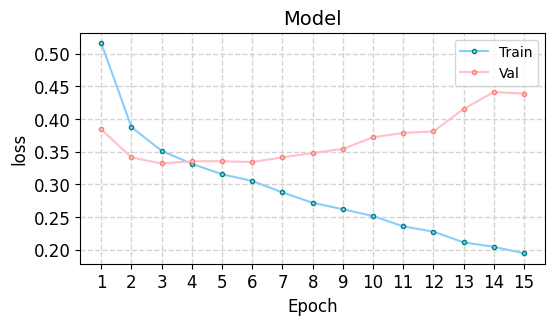

In [38]:
draw_pics(record, 'loss', img_save=False, show=True)

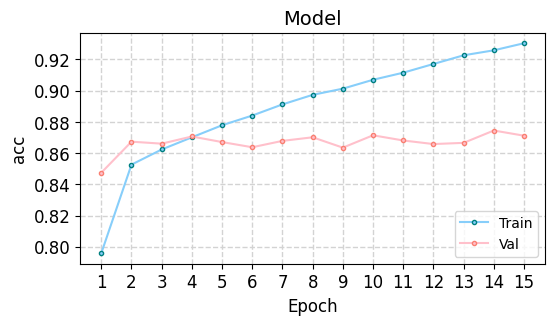

In [39]:
draw_pics(record, 'acc', img_save=False, show=True)

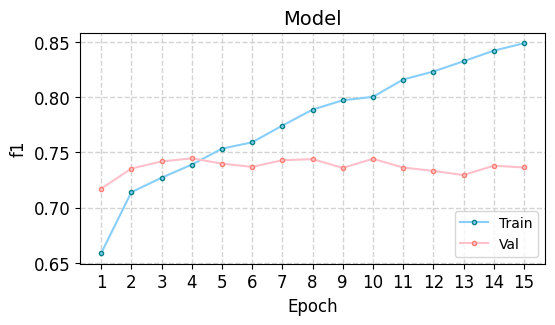

In [40]:
draw_pics(record, 'f1', img_save=False, show=True)

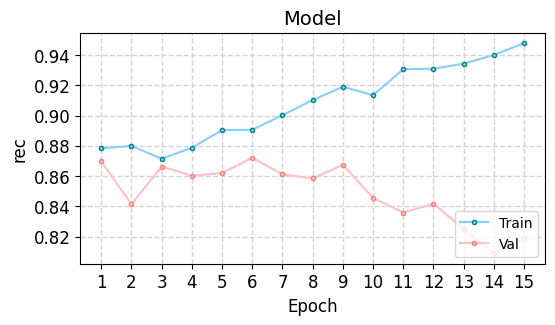

In [41]:
draw_pics(record, 'rec', img_save=False, show=True)

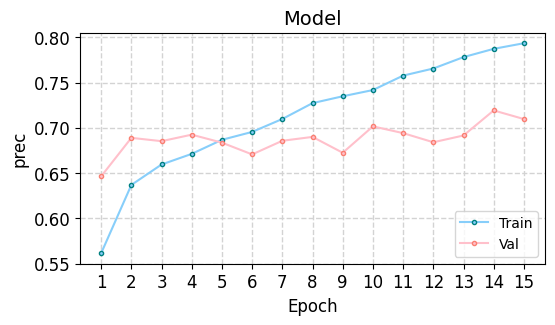

In [42]:
draw_pics(record, 'prec', img_save=False, show=True)

In [43]:
# predict dataloader
def predict(data_loader, model):

  tokenizer = AutoTokenizer.from_pretrained(parameters['config'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  total_preds = []
  model.eval()
  with torch.no_grad():
    for data in data_loader:
        head_ids, head_masks, head_token_type_ids, paragraph_ids, paragraph_masks, paragraph_token_type_ids = [t.to(device) for t in data]
        headline = [head_ids, head_masks, head_token_type_ids]
        paragraph = [paragraph_ids, paragraph_masks, paragraph_token_type_ids]

        # forward pass
        logits = model(headline, paragraph)
        total_preds.append(get_pred(logits).item())
    
  return total_preds

In [44]:
total_preds = predict(test_loader, model)

In [45]:
len(total_preds)

18979

In [46]:
submission_df = pd.DataFrame()
submission_df = test_df
submission_df['LABEL'] = total_preds

In [47]:
def transform_class(class_):
  label = 0
  if class_ == 'clickbait':
    label = 1
  return label

In [48]:
submission_df['truthClass'] = submission_df['truthClass'].apply(transform_class)

In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(submission_df['truthClass'], submission_df['LABEL'])

0.8495178881922124

<Axes: >

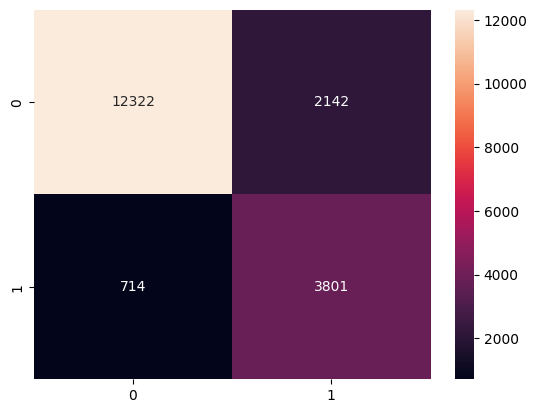

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(submission_df['truthClass'], submission_df['LABEL'])
sns.heatmap(cf_matrix, annot=True, fmt='.20g')

In [51]:
from sklearn.metrics import classification_report
target_names = ['non-clickbait', 'clickbait']
print(classification_report(submission_df['truthClass'], submission_df['LABEL'], target_names=target_names))

               precision    recall  f1-score   support

non-clickbait       0.95      0.85      0.90     14464
    clickbait       0.64      0.84      0.73      4515

     accuracy                           0.85     18979
    macro avg       0.79      0.85      0.81     18979
 weighted avg       0.87      0.85      0.86     18979



In [52]:
test_df['truthClass'].value_counts()

0    14464
1     4515
Name: truthClass, dtype: int64

In [53]:
submission_df['LABEL'].value_counts()

0    13036
1     5943
Name: LABEL, dtype: int64

In [54]:
model_ = load_checkpoint('./clickbait_acc.pt', model, device)
total_preds = predict(test_loader, model_)
submission_df_ = pd.DataFrame()
submission_df_ = test_df
submission_df_['LABEL'] = total_preds

Model loaded from <== ./clickbait_acc.pt


In [55]:
accuracy_score(submission_df_['truthClass'], submission_df_['LABEL'])

0.8553664576637336

In [56]:
from sklearn.metrics import recall_score
recall_score(submission_df_['truthClass'], submission_df_['LABEL'])

0.7871539313399778

In [57]:
from sklearn.metrics import precision_score
precision_score(submission_df_['truthClass'], submission_df_['LABEL'])

0.6657924316223305

In [58]:
from sklearn.metrics import f1_score
f1_score(submission_df_['truthClass'], submission_df_['LABEL'])

0.7214046483304577

<Axes: >

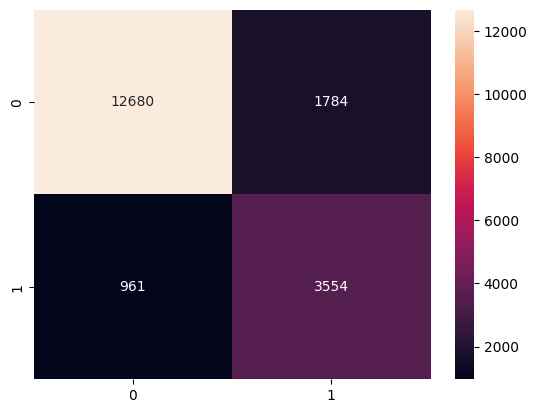

In [59]:
cf_matrix = confusion_matrix(submission_df_['truthClass'], submission_df_['LABEL'])
sns.heatmap(cf_matrix, annot=True, fmt='.20g')

In [60]:
print(classification_report(submission_df_['truthClass'], submission_df_['LABEL'], target_names=target_names))

               precision    recall  f1-score   support

non-clickbait       0.93      0.88      0.90     14464
    clickbait       0.67      0.79      0.72      4515

     accuracy                           0.86     18979
    macro avg       0.80      0.83      0.81     18979
 weighted avg       0.87      0.86      0.86     18979

